### AI vrs Human.

In this notebook we are going to create a pytorch model using torchtext and our custom dataset that identifies text generated by AI or Human.

We are going to use our custom dataset that we will load from my google drive. The dataset that we are going to use was found on [kaggle](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text).

### Installing Helper Packages
In the following code cell we are going to install the package called ``helperfns`` that provide us with some usefull helper functions for machine learning.

In [1]:
!pip install helperfns -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 13.1 MB/s eta 0:00:00


https://github.com/pytorch/text


Next we are going to install torchtext with the version of pytorch that matches it's requirements.

In [2]:
!pip install torch==2.3.0  torchtext==0.18.0 torchvision==0.18.0 torchaudio==2.3.0 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 810.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0

### Imports

In the following code cell we are going to import all the packages that we are going to use throughout this notebook

In [76]:
import json
import time
import torch
import os
import random
import torchtext
import spacy
import re
import en_core_web_sm
from google.colab import files

from torchtext import data
from collections import Counter
from torchtext import vocab
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_wordcloud, plot_classification_report
from helperfns.utils import hms_string
from helperfns.text import clean_sentence
from torch import nn
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import torch.nn.functional as F

import warnings
import nltk
nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings('ignore')

torch.__version__, torchtext.__version__

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


('2.3.0+cu121', '0.18.0+cpu')

### Setting seeds


In the following code cell we are going to set the seed to all random operations for reproducivity.

In [4]:
SEED = 23
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Device
In the following code cell we are going to get ``gpu`` device if possible

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data

The dataset that we are going to use was founc on kaggle:

https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text


The dataset contain the text and label with a coloumn name `generated` which indicated if the text has been generated by AI or not `1` meaning the text was generated by AI `0` otherwise.

In [6]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']

In [7]:
!kaggle datasets download shanegerami/ai-vs-human-text --unzip

Dataset URL: https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text
License(s): other
100% 348M/350M [00:19<00:00, 18.2MB/s]
100% 350M/350M [00:19<00:00, 19.1MB/s]


Let's read our dataset into a pandas dataframe.

In [8]:
dataframe = pd.read_csv('AI_Human.csv')
dataframe.head(2)

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0


Next we are going to change the labels from `0` and `1` to `human` and `ai` respectively

In [9]:
dataframe.generated = dataframe.generated.apply(lambda x: 'human' if x == 0 else 'ai')
dataframe.head(2)

,text,generated
0,Cars. Cars have been around since they became ...,human
1,Transportation is a large necessity in most co...,human


First let's count how many examples of text that were generated by `AI` and how many of those which were generated by `human`.

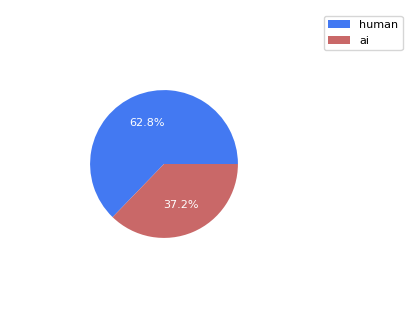

In [10]:
generated	= {i:0 for i in dataframe.generated.unique()}
for val in dataframe.generated:
  generated[val] += 1

plt.figure(figsize=(4, 4))
plt.pie(generated.values(), labels=generated.keys(), autopct='%1.1f%%', textprops={'color': 'white', 'fontsize':8}, radius=.6,
        colors=['#4379F2', '#C96868'])
plt.legend(fontsize=8, labels=list(generated.keys()), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

As we can see we have more ``human`` text than `ai` text, so we want to balance our dataset and visualize it.

In [11]:
# Separate the majority and minority classes
majority_class = dataframe[dataframe['generated'] == dataframe['generated'].value_counts().idxmax()]
minority_class = dataframe[dataframe['generated'] == dataframe['generated'].value_counts().idxmin()]

# Downsample majority class to the size of the minority class
majority_downsampled = resample(
    majority_class,
    replace=False,  # without replacement
    n_samples=len(minority_class),  # match minority class size
    random_state=SEED  # for reproducibility
)

# Combine downsampled majority and original minority
balanced_df = pd.concat([majority_downsampled, minority_class])
balanced_df.tail(3)

,text,generated
487217,"As an eighth grade student, I believe that att...",ai
487222,It is a common belief that having a broad know...,ai
487232,I firmly believe that governments worldwide sh...,ai


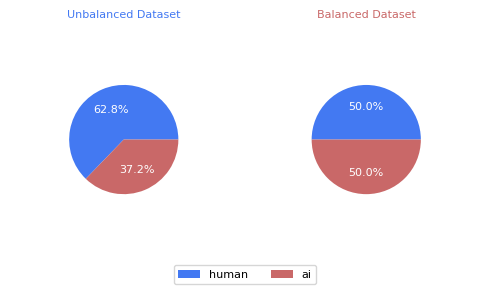

In [12]:
generated_counts = dataframe.generated.value_counts()
balanced_generated = balanced_df.generated.value_counts()

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(5, 3))

# Colors for the pie chart segments
colors = ['#4379F2', '#C96868']

# Plot the first pie chart
axes[0].pie(generated_counts, labels=generated_counts.index, autopct='%1.1f%%',
            textprops={'color': 'white', 'fontsize':8}, radius=0.6, colors=colors)
axes[0].set_title("Unbalanced Dataset", fontsize=8, color=colors[0])

# Plot the second pie chart
axes[1].pie(balanced_generated, labels=balanced_generated.index, autopct='%1.1f%%',
            textprops={'color': 'white', 'fontsize':8}, radius=0.6, colors=colors)
axes[1].set_title("Balanced Dataset", fontsize=8, color=colors[1])

# Add a single legend for both charts
fig.legend(generated_counts.index, loc="upper center", bbox_to_anchor=(0.5, 0.1), ncol=2, fontsize=8)

# Adjust layout and remove axis for a cleaner look
plt.tight_layout()
plt.show()

Next we are going to split our dataset into 3 subsets which are:

1. train
2. test
3. val

In [13]:
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=SEED)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=SEED)

### Data Analyisis

In this section of the notebook we are going to check how the data is distributed within our 3 sets.

First we are going to have a look at how the labels are distributed in the `training`, `validation` and `testing` subsets.

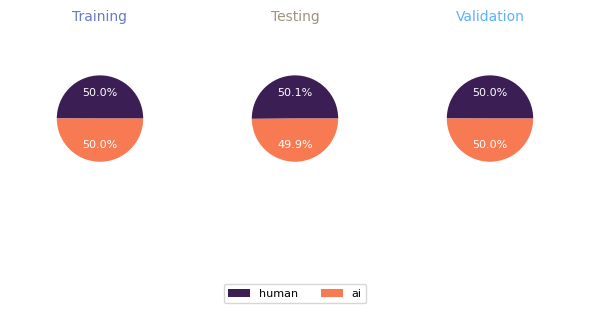

In [14]:
train_dist_generated	= {i:0 for i in train_df.generated.unique()}
for val in train_df.generated:
  train_dist_generated[val] += 1

test_dist_generated	= {i:0 for i in test_df.generated.unique()}
for val in test_df.generated:
  test_dist_generated[val] += 1

val_dist_generated	= {i:0 for i in valid_df.generated.unique()}
for val in valid_df.generated:
  val_dist_generated[val] += 1


colors = ['#3B1E54', '#F87A53']
fig, axes = plt.subplots(1, 3, figsize=(6, 4))

axes[0].pie(train_dist_generated.values(), labels=train_dist_generated.keys(), autopct='%1.1f%%',
            textprops={'color': 'white', 'fontsize':8}, radius=.6,
            colors=colors
            )
axes[0].set_title("Training", fontsize=10, color='#667BC6')

axes[1].pie(test_dist_generated.values(), labels=test_dist_generated.keys(), autopct='%1.1f%%',
            textprops={'color': 'white', 'fontsize':8}, radius=.6,
            colors=colors
            )
axes[1].set_title("Testing", fontsize=10, color='#A0937D')

axes[2].pie(val_dist_generated.values(), labels=val_dist_generated.keys(), autopct='%1.1f%%',
            textprops={'color': 'white', 'fontsize':8}, radius=.6,
            colors=colors)
axes[2].set_title("Validation", fontsize=10, color='#5AB2FF')

fig.legend(generated_counts.index, loc="upper center", bbox_to_anchor=(0.5, 0.1), ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

We can see that among all the `3` sets there is a balance between the text that was generated by AI and the one that was generated by human. In the next step we are going to visualize how frequently words appears in the train, validation and test text.

In [15]:
train_text_counter = Counter()
for line in train_df.text:
    train_text_counter.update(line.lower().split())

test_text_counter = Counter()
for line in test_df.text:
    test_text_counter.update(line.lower().split())

valid_text_counter = Counter()
for line in valid_df.text:
    valid_text_counter.update(line.lower().split())

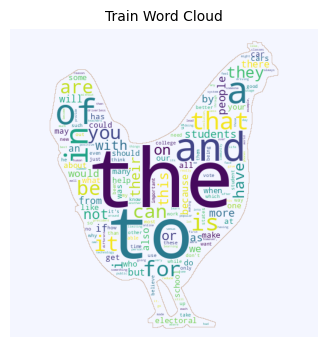

In [16]:
plot_wordcloud(train_text_counter, title="Train Word Cloud", mask="chicken", background_color="#F4F6FF", figsize=(4, 4),
               fontsize=10)

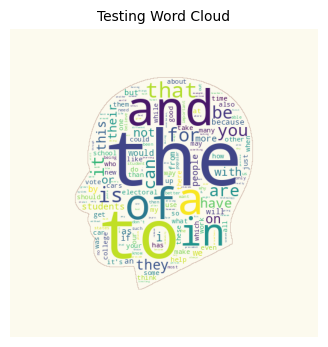

In [17]:
plot_wordcloud(test_text_counter, title="Testing Word Cloud", mask="head", background_color="#FCFAEE", figsize=(4, 4),
               fontsize=10)

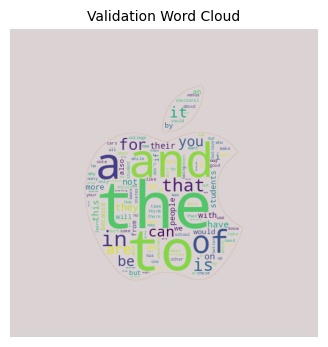

In [18]:
plot_wordcloud(valid_text_counter, title="Validation Word Cloud", mask="apple", background_color="#DBD3D3", figsize=(4, 4),
               fontsize=10)

We can see that most of the words that are commonly appearing in this copus are `"stopwords"`. Which means we need to remove most of those words during text preprocessing.

Next let's visualize how many examples are there in each `set`.

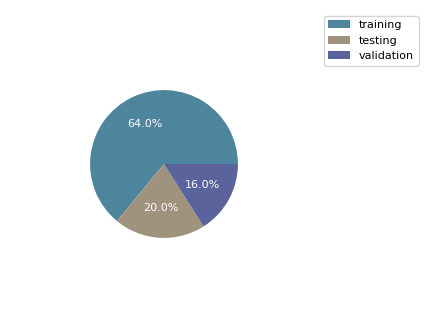

In [19]:
plt.figure(figsize=(4, 4))
plt.pie([len(train_df), len(test_df), len(valid_df)], labels=['training', 'testing', 'validation'],
        autopct='%1.1f%%', textprops={'color': 'white', 'fontsize':8}, radius=.6,
        colors=['#4D869C', '#A0937D', '#5A639C'])
plt.legend(fontsize=8, labels=['training', 'testing', 'validation'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

``64%`` of the data is in the training set, ``20%`` in the test set and ``16%`` in the validation set. We can display this using a table:

In [71]:
columns = ["Set", "Total"]
data = [
    ["TRAINING", f"{len(train_df):,}"],
    ["TESTING", f"{len(test_df):,}"],
    ["VALIDATION", f"{len(valid_df):,}"],
    ["TOTAL", f"{len(test_df) + len(train_df) + len(valid_df):,}"],
]
tabulate_data(columns, data, title="SETS EXAMPLES")

SETS EXAMPLES
+------------+---------+
| Set        |   Total |
+------------+---------+
| TRAINING   | 232,240 |
| TESTING    |  72,576 |
| VALIDATION |  58,060 |
| TOTAL      | 362,876 |
+------------+---------+




### Features and Labels
Our fetures are the actual ``text`` in the dataframes which is the column named ``text`` and our labels will come from the column called `generated`. In the following code cell we are going to read features and labels in a numpy arrays for each set.

In [20]:
# train
train_texts = train_df.text.values
train_labels = train_df.generated.values

# test
test_texts = test_df.text.values
test_labels = test_df.generated.values

# val
val_texts = valid_df.text.values
val_labels = valid_df.generated.values

### Text Preprocessing

In our text processing pipeline we need to do the following steps:
1. `text_cleaning`
- First we are going to remove punctuation url's and numbers, from the text. For that we are going to use a function called `clean_sentence`  which cleans the text, by removing punctuations, numbers, tags, urls, etc from a sentence.

2. ``tokenize sentences``
* this is the process of converting a sentence or text into senquence of word. For this process we are going to use a pre-trained model from ``spacy`` language model.

3. `stop_words_removal`
* We are then going to remove stopwords from our text.

4. ``vocabulary``
* We will to create a vocabulary based on our sentences that are in the train dataset. A ``vocabulary`` is esentially a word to index mapping that allows us to reference the word with their integer representation, since machine leaning models does not understand words. This vocabulary will be used during model training and also can be used at model inference.

### Tokenizer
In the following code cell we are going to get a tokenier object that will convert a sentence into a sequence of word using the ``spacy-en`` language model. The reason we are using the english langauge model it's because our ``text`` are in ``english``.

In [21]:
eng_stopwords = stopwords.words('english')
def stopwords_remover(words: list[str]) -> list[str]:
  return [word for word in words if word not in eng_stopwords]

stopwords_remover("this is a wing.".split())

['wing.']

In [22]:
tokenizer = data.utils.get_tokenizer('spacy', 'en')
tokenizer("This is a boy.")

['This', 'is', 'a', 'boy', '.']

In [23]:
def clean_sentence(sent: str, lower: bool = True) -> str:
    sent = sent.lower() if lower else sent
    sent = re.sub(
        r"(@|#)([A-Za-z0-9]+)", " ", sent
    )
    sent = re.sub(
        r"([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+", " ", sent
    )
    sent = re.sub(r"https?\S+", " ", sent, flags=re.MULTILINE)  # removing url's
    sent = re.sub(r"\d", " ", sent)  # removing none word characters
    sent = re.sub(
        r"[^\w\s\']", " ", sent
    )
    sent = re.sub(r"\s+", " ", sent).strip()  # remove more than one space
    return sent


### Vocabulary
In the following code cell we are going to create a vocabulary object from ``torchtext``.  So we are going to use the ``Counter`` module from collections to generate these counts from our ``train`` text.

We are going to specify the ``min_freq`` to ``5`` meaning that the words that does not appear at least ``5`` times will be converted to unknown. We are also going to specify the special tokens during creation of the vocabulary object.

In [24]:
counter = Counter()
for line in train_texts:
  line = clean_sentence(line)
  tokens = tokenizer(line)
  counter.update(stopwords_remover(tokens))

In [25]:
#  our special tokens are (unknown, padding, start of sentence, end of sentence)
vocabulary = vocab.vocab(counter, min_freq=5, specials=('[unk]', '[pad]', '[sos]', '[eos]'))

### STOI - ``String To Integer``
This will be a dictionary that contains a string to integer mapping which will be our actual vocabulary. In the following code cell we are going to create object called stoi which is essentially a dictionary of word to index mapping. This dictionary will be used during training as well as during model inference.

In [26]:
stoi = vocabulary.get_stoi()
print("Vocab Size: ", len(stoi))

Vocab Size:  47619


### Text Pipeline
After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the ``text_pipeline`` function comes into play. So this function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay (``stoi``) will be converted to an unkown (``'[unk]'``) token (0).


> Note that our `text_pipeline` should also do the same process during vocabulary creation.

In [27]:
def text_pipeline(x: str):
  values = list()
  line = clean_sentence(x)
  tokens = tokenizer(x)
  tokens = stopwords_remover(tokens)
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['[unk]']
    values.append(v)
  return values

### Label pipeline
Our labels for now are just textual. We also need to convert these labels into numbers. This is very simple what we need to do is to get all the uniqe labels and then create a ``labels_vocab`` which is a label to integer representation.

In [28]:
labels_dict = {k: v for v, k in enumerate(train_df.generated.unique())}
labels_dict

{'human': 0, 'ai': 1}

The ``label_pipeline`` function will then takes in the label and then returns us an integer representation of that label.

In [29]:
label_pipeline = lambda x: labels_dict[x]

### Pretrained vectors
In the following code cell we are going to download the predtrained word vectors. We are going to use the ``GloVe.840B.300d``. These are pretrained vectors that were trained with about ``~840B`` words and have a vector representation of a word in ``300`` dimension for each word.

In [30]:
EMBEDDING_DIM = 300
glove_vectors = vocab.GloVe(name='840B', dim=EMBEDDING_DIM)

.vector_cache/glove.840B.300d.zip: 2.18GB [06:57, 5.21MB/s]                            
100%|█████████▉| 2196016/2196017 [05:38<00:00, 6485.81it/s]


### Creating Embedding matrix
Now that we have our glove vectors we need to costomize them so that they fit our use case. We are going to create an embedding matrix that suits the our vocabulary. So essentially this embedding matrix will be the word to vector mapping for all the words that arein our vocabulary.

In [31]:
VOCAB_SIZE = len(stoi)
EMBEDDING_MATRIX= torch.zeros([VOCAB_SIZE, EMBEDDING_DIM])
for i, word in enumerate(vocabulary.get_itos()):
  EMBEDDING_MATRIX[i] = glove_vectors[word]

In the followig code cell we are going to check the embedding matrix for the word ``"people"``.

In [32]:
EMBEDDING_MATRIX[stoi['people']]

tensor([-1.9686e-01,  1.1579e-01, -4.1091e-01, -4.6998e-01, -2.9972e-01,
         6.7654e-02, -8.8857e-02,  3.2210e-02,  2.5616e-01,  3.2108e+00,
        -2.7731e-01,  7.0743e-02,  2.1918e-02, -1.0867e-01, -1.5828e-01,
        -1.4976e-01, -5.1743e-01,  7.3892e-01, -4.4249e-01, -1.2340e-01,
         4.4607e-02,  1.9652e-01,  4.3265e-03, -5.3208e-02,  3.1904e-01,
        -3.3364e-01,  9.6965e-02,  8.2695e-02, -7.0981e-02, -2.4714e-01,
         2.9223e-01, -3.7456e-02, -4.6527e-01, -2.2640e-01,  4.3721e-01,
         5.2628e-02, -2.3859e-01, -1.6096e-01, -1.4652e-01,  3.2018e-01,
        -1.1260e-01, -1.8967e-02, -1.5709e-01, -9.2215e-02,  7.6994e-02,
        -3.0975e-02, -1.0931e-01,  1.3912e-01,  1.1352e-02, -1.3433e-01,
        -7.5631e-01, -1.5791e-01, -2.6654e-02, -2.1694e-01,  2.7343e-01,
         5.9012e-03, -7.3400e-02, -6.6727e-02, -1.8656e-01,  1.0346e-01,
        -2.4448e-03, -4.1683e-01, -5.6282e-01,  3.4100e-01,  2.5238e-01,
        -2.2164e-01, -1.6711e-01,  9.6288e-03,  1.4

### Creating Dataset for Training
In the following code cell we are going to create a dataset class called `AIHumanDataset`. This dataset will takes in the labels and the text of a set.

In [33]:
class AIHumanDataset(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(AIHumanDataset, self).__init__()
    self.labels = labels
    self.text = text

  def __getitem__(self, index):
    return self.labels[index], self.text[index]

  def __len__(self):
    return len(self.labels)

### ``collate_fn``
We are going to create a collate function called ``tokenize_batch``. This function actually takes in a batch and does the preprocessing of the ``text`` and ``labels``. This function will be passed to the ``DataLoader`` class to do the preprocessing of ``features`` and ``labels``.

### ``tokenize_batch`` function:

* this function takes in a batch in each set and convert the features and labels to integer representation.
* It goes ahead and ``pad`` and ``truncate`` the sequence to the same length and returns ``labels`` and ``features``.

In [34]:
def tokenize_batch(batch, max_len=300, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, text_list = [], []
  for _label, _text in batch:
    labels_list.append(label_pipeline(_label))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  #  the labels will be torch long tensors since it is a multi-class classification.
  features = torch.cat(text_list, dim=0)
  return torch.FloatTensor(labels_list), features

### Datasets
In the following code cell we are going to create the datasets for all our three sets using the `AIHumanDataset` class.

In [35]:
train_dataset = AIHumanDataset(train_labels, train_texts)
test_dataset = AIHumanDataset(test_labels, test_texts)
val_dataset = AIHumanDataset(val_labels, val_texts)

### Iterators
In the following code cell we are going to create loaders using the ``DataLoader`` class from ``torch.utils.data`` for our ``3`` sets. We are going to use the ``batch_size`` of ``128`` and our ``collate_function`` is ``tokenize_batch``. For the validation and testing dataset we are going to set the ``shuffle`` to ``False`` because there's no need fo us to shuffle these examples.

In [36]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

Checking a single Batch Data

In [37]:
lbl, txt = next(iter(train_loader))

Labels in the first batch.

In [38]:
lbl

tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
        1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
        1., 0.])

The first sentence in the batch.

In [39]:
txt[0]

tensor([    0,     0,     0,     0,     0,     0,   900,   347,     0,     0,
            0,   797,     0,     0,     0,     0,     0,     0,  2496,    87,
            0,     0,   465,     0,     0,  1109,     0,     0,     0,     0,
           35,     0,  1295,     0,  1361,    82,     0,     0,     0,     0,
            0,     0,     0,     0,    30,  2251,  7415,  2224,     0,     0,
            0,     0,     0,  4763,     0,    30,     0,     0,     0,    68,
           30,  7415,     0,     0,     0,   392,    45,     0, 20706,  3202,
           40,     0,  5008,  4404,     0,   926,   269,     0,    30,     0,
         1361,     0,  1109,     0,     0,     0,  2621,    27,    87,    28,
         2880,     0,     0,     0,     0,  2040,   383,    70,    40,   516,
         1130,     0,     0,     0,     0, 13062,     0,  5042,   598,   183,
          735,    30,     0,     0,    16,     0,    11,    83,     8,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

### Models.

Next we are going to create our model that does AIHuman Detection based on the text provide.

### `AIHumanBiLSTM`

In the following code cell we are going to build a model using `LSTM` layers.

In [40]:
class AIHumanBiLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_size,
               hidden_size, output_size, num_layers,
               bidirectional, dropout, pad_index
               ):
    super(AIHumanBiLSTM, self).__init__()
    self.embedding = nn.Sequential(
          nn.Embedding(
              vocab_size, embedding_size, padding_idx=pad_index
        )
    )

    self.lstm = nn.Sequential(
          nn.LSTM(
              embedding_size, hidden_size = hidden_size,
              bidirectional=bidirectional,
              num_layers=num_layers,
              dropout = dropout,
              batch_first=True,
          )
    )
    self.out = nn.Sequential(
        nn.Linear(hidden_size * 2, out_features=output_size)
    )

  def forward(self, text, text_lengths):
    embedded = self.embedding(text)
    packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths, batch_first=True, enforce_sorted=False
    )
    packed_output, (hidden, cell) = self.lstm(packed_embedded)
    if self.lstm[0].bidirectional:
      hidden = torch.cat([hidden[-1], hidden[-2]], dim=-1)
    else:
      hidden = hidden[-1]
    return self.out(hidden)

In the following code cell we are going to create a model instance of the `AIHumanBiLSTM` model.

In [41]:
INPUT_DIM = len(stoi)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1 if len(labels_dict) == 2 else len(labels_dict)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = stoi['[pad]']
bilstm = AIHumanBiLSTM(
              INPUT_DIM,
              EMBEDDING_DIM,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT,
              PAD_IDX
).to(device)
bilstm


AIHumanBiLSTM(
  (embedding): Sequential(
    (0): Embedding(47619, 300, padding_idx=1)
  )
  (lstm): Sequential(
    (0): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
  )
)

### Model Parameters

In the following code cell we are going to count parameters of each model achitecture and visualize it using a table.

In [42]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["bilstm", *count_trainable_params(bilstm)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+--------+--------------+------------------+
| MODEL  | TOTAL PARAMS | TRAINABLE PARAMS |
+--------+--------------+------------------+
| bilstm |   17,005,957 |       17,005,957 |
+--------+--------------+------------------+


### Loading Embedding Vectors
In the following code cells we are going to load the pretained custom vectors in our embedding layer to our models. We are going to load the embedding vectors tha suits our data using the ``model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)``

In [43]:
bilstm.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4457, -0.0416,  0.5734,  ...,  0.6434,  0.5133,  0.1925]],
       device='cuda:0')

### Optimizer and Criterion
In the following code cell we are going to define the ``optimizers``
 for all the 3 models and a single criterion. For the ``optimizer`` we are going to use the ``Adam`` optimizer with default parameters and for the criterion we are going to use the ``CrossEntropyLoss()`` function since this is a multi-class classification.

In [44]:
optimizer = torch.optim.Adam(bilstm.parameters())
criterion = nn.BCEWithLogitsLoss().to(device)

In the following code cell we are going to create our ``categorical_accuracy`` function, which is a function that calulates the the catecorical accuracy between the predicted labels and real labels.

In [45]:
def binary_accuracy(y_preds, y_true):
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float()
  return correct.sum() / len(correct)

### Training and evaluation functions.

In the following code cell we are going to create our ``train`` and ``evalute`` functions:

In [46]:
def train(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device)
    lengths = torch.tensor([len(i) for i in X])
    optimizer.zero_grad()

    predictions = model(X, lengths).squeeze(1)
    loss = criterion(predictions, y)
    acc = binary_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device)
      lengths = torch.tensor([len(i) for i in X])
      predictions = model(X, lengths).squeeze(1)
      loss = criterion(predictions, y)
      acc = binary_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Training Loop.

When training the model we are going to train each model surperately. And we are also going to keep on tracking the training history of each model. The following `History` class is a data structure for our training history.

In [47]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

### 1. Training the `LSTM` model

The folloing code cell will run a training loop for the `ltsm` model for `8` epochs.

In [48]:
def run_train_loop(model, model_name, train_loader, val_loader,  epochs=20, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
    data = [
        ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],
    ]
    columns = ["CATEGORY", "LOSS", "ACCURACY", "ETA"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In [49]:
EPOCHS = 8

history, elt, last_saved_epoch = run_train_loop(
    bilstm, 'lstm.pt', train_loader, val_loader, EPOCHS,
    optimizer=optimizer, criterion=criterion
)

EPOCH: 01/08 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.245 |    0.893 | 0:21:36.32 |
| Validation | 0.047 |    0.987 |            |
+------------+-------+----------+------------+
EPOCH: 02/08 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.028 |    0.991 | 0:21:28.12 |
| Validation | 0.019 |    0.994 |            |
+------------+-------+----------+------------+
EPOCH: 03/08 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.012 |    0.996 | 0:21:16.56 |
| Validation | 0.014 |    0.996 |            |
+------------+-------+----------+------------+
EPOCH: 04/08 not saving...
+------------+-------+---

Next we are going to save the the files that we are going to use for model inference.

In [50]:
with open("vocab.json", 'w') as f:
  f.write(json.dumps(stoi, indent=2))

with open("labels_dict.json", 'w') as f:
  f.write(json.dumps(labels_dict, indent=2))

print("Done!")

Done!


Then we going to download the `static` file.

In [51]:
files.download('lstm.pt')
files.download('labels_dict.json')
files.download('vocab.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Next we are going to check the the last saved epoch and the total training time the ``LSTM`` model took.

In [52]:
rows = [
      ["TOTAL EPOCHS", f'{EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(elt)}']
]
tabulate_data(['', 'value'], rows, "LSTM MODEL TOTAL TRAINING TIME AND LAST SAVED EPOCH")

LSTM MODEL TOTAL TRAINING TIME AND LAST SAVED EPOCH
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |          8 |
| LAST SAVED EPOCH    |          6 |
| TOTAL TRAINING TIME | 2:49:48.35 |
+---------------------+------------+


### Training History

In the following code cells we will be visualizing the training that we observed during training the model. The first plot that we will plot is about the training time that the model took to complete each epoch.

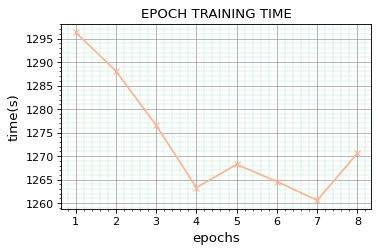

In [59]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, "x-", markerfacecolor = "#FFB38E", color='#FFB38E', label='lstm')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation loss using a line graph for each model that was observed during model training.

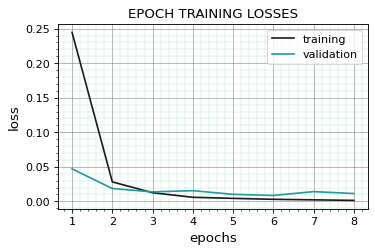

In [60]:

epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, color='#1A1A1D', label='training')
plt.plot(epochs, history.val_losses, color='#219B9D', label='validation')
plt.title("EPOCH TRAINING LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation accuracies using a line graph for each model that was observed during model training.

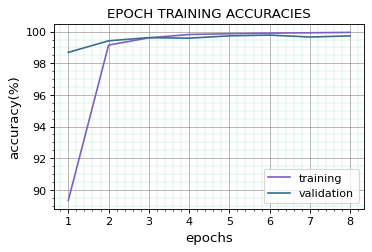

In [62]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [acc * 100 for acc in history.train_acc], color='#7E60BF', label='training')
plt.plot(epochs, [acc * 100 for acc in history.val_acc], color='#3A6D8C', label='validation')

plt.title("EPOCH TRAINING ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### Best model evaluations.

In the following code cell we are going to evaluate the best saved model for each model achitecture.

In [63]:
bilstm.load_state_dict(torch.load('lstm.pt'))
bilstm_test_loss, bistm_test_acc = evaluate(bilstm, test_loader, criterion)

print(f'Test Loss: {bilstm_test_loss:.3f} | Test Acc: {bistm_test_acc*100:.2f}%')


Test Loss: 0.008 | Test Acc: 99.80%


Next we are going to make predictions based with our test dataset for using our model.

In [68]:
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  predictions = []
  with torch.no_grad():
    for (y, X) in iterator:
      X = X.to(device)
      lengths = torch.tensor([len(i) for i in X])
      y_pred = model(X, lengths).squeeze(1)
      y_prob = F.sigmoid(y_pred).round().long()
      labels.append(y.cpu())
      predictions.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0).numpy()
  predictions = torch.cat(predictions, dim = 0).numpy()
  return labels, predictions
y_true, y_preds = get_predictions(bilstm, test_loader, device)

### Confusion matrix

In the following code cell we are going to plot the `Confusion Matrix` of our model.

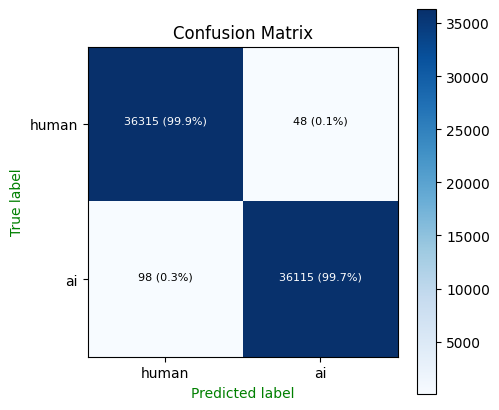

In [75]:
plot_complicated_confusion_matrix(y_true, y_preds,
  labels_dict.keys(), fontsize=8, figsize=(5, 5)
)

### Classification Report

Next we are going to plot the classification report of our model based on the test dataset.

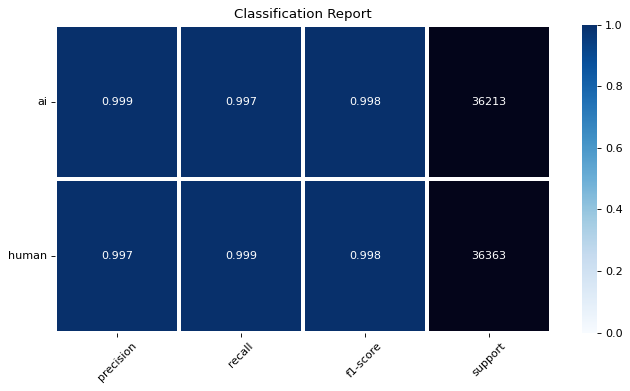

In [78]:
fig, ax = plot_classification_report(
    y_true, y_preds,
    title='Classification Report',
    figsize=(10, 5), dpi=80,
    target_names = labels_dict.keys()
    )

### Model Inference

In this section we are going to test our modelnif it can make predictions based on the user input.

In the following code cell we are going to make predictions with the best model. We will have the function called `inference_preprocess_text` which is a function that process the text for inference.

In [79]:
def inference_preprocess_text(text, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_holder = torch.zeros(max_len, dtype=torch.int32) # fixed size tensor of max_len with  = 0
  processed_text = torch.tensor(text_pipeline(text), dtype=torch.int32)
  pos = min(max_len, len(processed_text))
  if padding == "pre":
    text_holder[:pos] = processed_text[:pos]
  else:
    text_holder[-pos:] = processed_text[-pos:]
  text_list= text_holder.unsqueeze(dim=0)
  return text_list

In [87]:
classes = list(labels_dict.keys())
def predict_ai(model, sentence, device):
    model.eval()
    with torch.no_grad():
      tensor = inference_preprocess_text(sentence).to(device)
      length = torch.tensor([len(t) for t in tensor])
      prob = torch.sigmoid(model(tensor, length).squeeze(0)).cpu().item()
      prediction = 1 if prob >= 0.5 else 0
      class_name = classes[prediction]
      confidence = prob if prediction == 1 else 1 - prob
      pred_data = [
          ["class_id",  prediction],
          ["class_name",  class_name],
          ["probability",  round(float(confidence), 3)],
      ]
      return dict(pred_data)

### AI Generated Text.

In [88]:
with open('ai.txt', 'r') as reader:
  ai = reader.read()

print("AI Text: ", ai)

print("\n\n")
predict_ai(bilstm, ai, device=device)

AI Text:  "Gun control is a big issues in lots of countries. Peoples got diff'rent opinions on it. Me, I think we need stricter gun control laws. Because, like, there's too many shootings and stuff.

First reason is that guns r dangerous. They can oil peoples. Accidents can happen. Or peoples can get angry and shoot sum1. It's just too risky. My friend, his cousin, he got shot by his friend. He didn meant to, but he was playing around, and it went off. Now he's in a wheelchair. It's just sad.

Second reason is that there's too much violence. In America, there's like a mass shooting every week. It's crazy. Peoples got guns, and they think they can do whatever they want. They shoot up schools, churches, concerts. Its like, why can't we just have a nice life? Why we have to be scared of getting shot?

Third reason is that guns r easy to get. Anybody can get one. IOU don't need a license or anything. Just go to a store and buy one. That's not right. There should be stricter laws. Make it h

{'class_id': 1, 'class_name': 'ai', 'probability': 0.998}

### Human Text

In [89]:
with open('human.txt', 'r') as reader:
  human = reader.read()

print("Human Text: ", human)
print("\n\n")
predict_ai(
    bilstm,
    human,
    device=device
)


Human Text:  "Today, the majority of humans own and operate cell phones on a daily basis.

In essay form, explain if drivers should or should not be able to use cell phones in any capacity while operating a vehicle.

Drivers should not be able to use their phones while driving. People are killed everyday by using their phones while driving. Sometimes people end up killing others while texting and driving. Laws have been passed to prevent texting and driving, but many people still do it. These careless people make it difficult for other drivers to feel safe on the road.

You are more likely to crash if you're texting and driving. You are looking at your phone which causes your eyes to be taken away from the road. By the time you look back on to the road you could be seconds away from causing an accident. This wives you very little time to react and usually results in death or injury. You can just as easily pull over to the side of the road and text whoever you are texting. Or you could 

{'class_id': 0, 'class_name': 'human', 'probability': 1.0}